# Toonify

Please ensure that you're using a GPU runtime

First some setup:

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 33.42 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/stylegan2
CPU says hello.
GPU says hello.


In [3]:
!mkdir raw
!mkdir aligned
!mkdir generated

## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the toon model)

Results will be placed in the stylegan2/generated folder

In [25]:
# 아베
#!wget https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg -O raw/example.jpg
# 아이유
#!wget https://i.pinimg.com/564x/50/cd/f3/50cdf35759b6340d683ec9a9bda726e0.jpg -O raw/example.jpg
# 수지
!wget http://ph.spotvnews.co.kr/news/photo/201909/318254_395152_1351.jpg -O raw/example.jpg

--2020-12-04 13:03:25--  http://ph.spotvnews.co.kr/news/photo/201909/318254_395152_1351.jpg
Resolving ph.spotvnews.co.kr (ph.spotvnews.co.kr)... 175.126.113.20
Connecting to ph.spotvnews.co.kr (ph.spotvnews.co.kr)|175.126.113.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 743568 (726K) [image/jpeg]
Saving to: ‘raw/example.jpg’

raw/example.jpg     100%[===================>] 726.14K   470KB/s    in 1.5s    

2020-12-04 13:03:27 (470 KB/s) - ‘raw/example.jpg’ saved [743568/743568]



In [26]:
import pretrained_networks

# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

In [27]:
!python align_images.py raw aligned

In [35]:
!python project_images.py --num-steps 1500 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "example_01.png"...


In [36]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


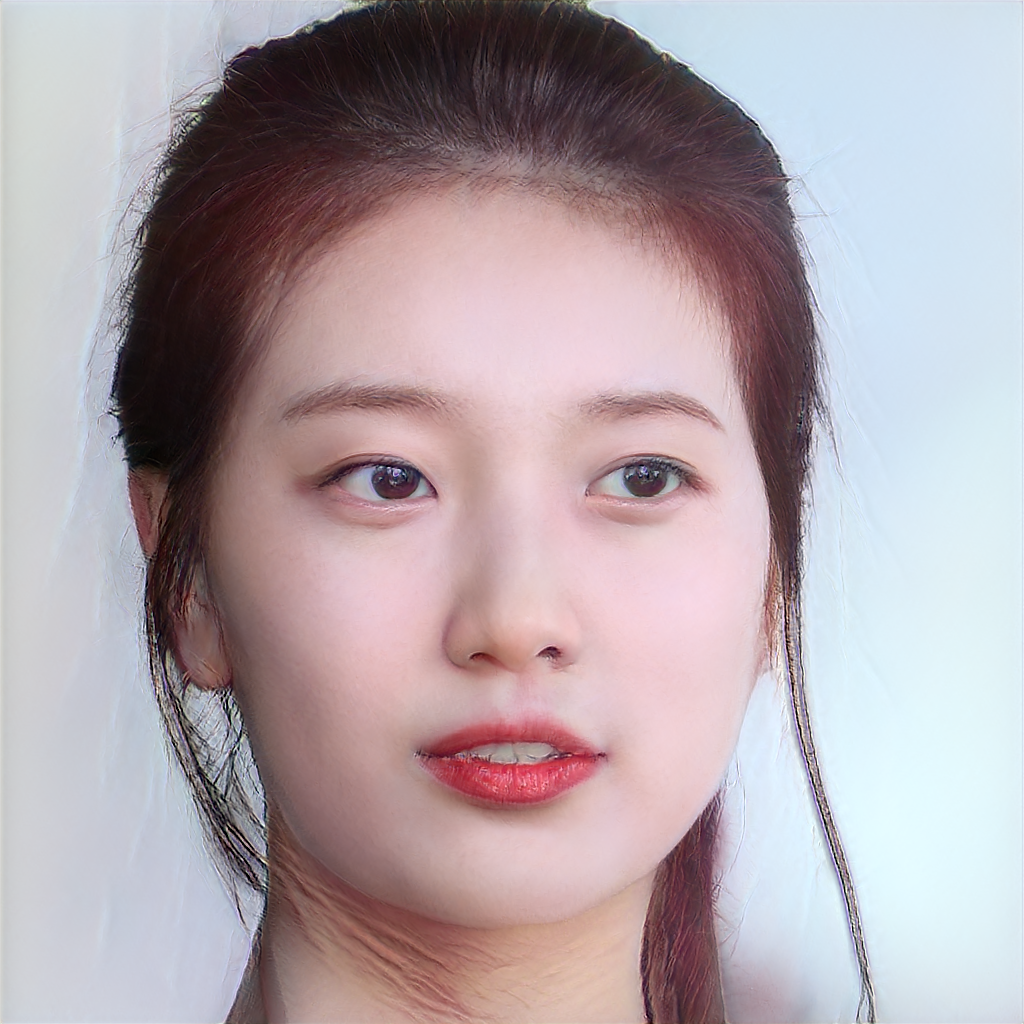

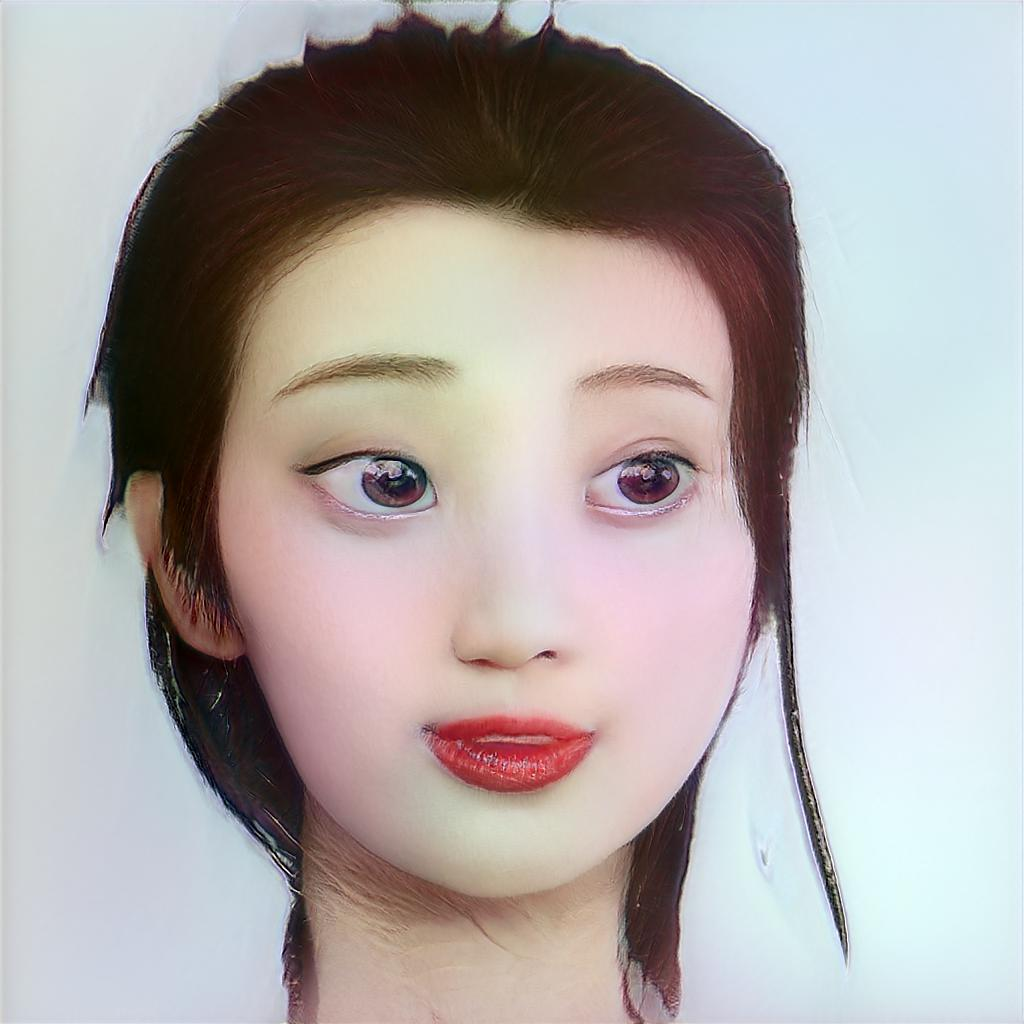

In [37]:
from IPython.display import Image 
embedded = Image(filename="generated/example_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_01-toon.jpg", width=256)
display(tooned)